# CEIA - VISIÓN POR COMPUTADORA
## TP2 - Integrantes
###
* Ruiz Otondo, Juan
* Torres, Dimas
* Villanueva, Cecilia Azul

## Librerias y funciones

In [109]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

##### Funciones

In [110]:
def drawFrameNum(img, num, c, s):
    """
    Dibuja  el número de frame sobre la imagen
    Devuelve la imagen con el texto
    """
    cv.putText(img, f'Frame {num}', (30, 30), cv.FONT_HERSHEY_SIMPLEX, s, c, 2, cv.LINE_AA)

    return img

In [111]:
def drawRectangle(img, pt1, pt2, c, s):
    """
    Dibuja un rectángulo del área de interés sobre la imagen
    Devuelve la imagen con el rectangulo dibujada
    """
    pt2_a= tuple(x - 1 for x in pt2)
    
    cv.rectangle(img, pt1, pt2_a, c, s, cv.LINE_8)

    return img

In [112]:
def drawMatrix(image, matrix, c , s ):
    """
    Dibuja la matriz de enfoque sobre la imagen
    Devuelve la imagen con la matriz dibujada
    """

    for [(x1, y1), (x2, y2)] in matrix:

        image_r = cv.rectangle(image, (x1, y1), (x2, y2), c, s, cv.LINE_8)
       
    return image_r

In [113]:
# Función para mostrar una imagen
def showImage(imagen, titulo='Imagen'):

    """
    Muestra una imagen en una ventana
    """

    plt.imshow(cv.cvtColor(imagen, cv.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

In [114]:
def showMetric(metrics,percentile,title,ylabel):
    """
    Muestra una scatter plot de las métricas de enfoque.
    """
   
    # Calculate the threshold value
    threshold= np.percentile(metrics, percentile)

    # Plot
    plt.figure(figsize=(10, 6))

    # Focus metrics plot
    plt.plot(metrics, marker='o', linestyle='-', color='b', label='Métricas de enfoque')

    # Threshold line
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Percentil {percentile}%')

    # Frames above the threshold
    plt.scatter([i for i, m in enumerate(metrics) if m >= threshold], 
                [m for m in metrics if m >= threshold], 
                color='g', zorder=5, label=f'Frames arriba del percentil {percentile}%')

    # Title and labels
    plt.xlabel('Frame #')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='upper left')

    # show plot
    plt.grid(True)
    plt.show()


In [115]:
def getROI(image, roi_fraction=0.1):

    """
    Extrae una región de interés (ROI) central que cubre una fracción dada del frame.
    Devuelve la region de interes del frame (ROI) y las coordenadas de la ROI.
    """
    
    height, width = image.shape

    area=roi_fraction*height*width

    # Calculate ROI dimensions
    roi_width  = int(np.sqrt(area * (width / height)))
    roi_height = int(area / roi_width)
    
    # Center coordinates
    center_x, center_y = width // 2, height // 2
    
    # Calculate ROI bounds
    x_start = center_x - roi_width // 2
    y_start = center_y - roi_height // 2
    x_end = center_x + roi_width // 2
    y_end = center_y + roi_height // 2
    
    # Extract and return the ROI
    return image[y_start:y_end, x_start:x_end],[(x_start, y_start), (x_end, y_end)]

In [116]:
def getMatrix(img, rect, matrix_dim, sep):
    """
    Devuelve una lista con las coordenadas para armar la matriz de enfoque : matrix
    Devuelve los rectángulos de la imagen que corresponden a la matriz : rect_imgs

      'img_shape' : tamaño de la imagen para centrar la matriz
            'rect': son las dimensiones de los rectángulos (Ancho-Alto) 
            'sep' : longitud de equiespaciado entre rectángulos
      'matrix_dim': filas y columnas de la matriz NxM

    """

    img_h, img_w = img.shape[:2]
    r_w, r_h = rect
    n, m = matrix_dim

    x0, y0 = (0, 0)
    xn, yn = (x0 + r_w * n + sep * (m-1) , y0 + r_h * n + sep * (m-1))

    if xn-x0 > img_w or yn-y0 > img_h:
        return "Error - Dimensiones incorrectas", _
        
    # Ubicar en el centro
    x0 = (img_w - (xn-x0)) // 2
    y0 = (img_h - (yn-y0)) // 2

    matrix = []

    y = y0

    for r in range(1, n + 1):
        x = x0
        for c in range(1, m + 1):
            matrix.append([(x, y),  (x + r_w, y + r_h)])
            x = x + r_w + sep
        y = y + r_h + sep

    rect_imgs = []

    for [(x1, y1), (x2, y2)] in matrix:
        rect_imgs.append(img[y1:y2, x1:x2])    

    
    return matrix , rect_imgs

In [117]:

def getISM(frame_gris):
    
    """
     Función para calcular la métrica de enfoque de una imagen (image_quality_measure)
    """
    # Paso 1: Transformada de Fourier centrada
    f_transformada = np.fft.fft2(frame_gris)
    f_transformada_centrada = np.fft.fftshift(f_transformada)

    # Paso 2: Obtener espectro de magnitud
    espectro_magnitud = np.abs(f_transformada_centrada)

    # Paso 3: Calcular el valor máximo y definir el umbral
    valor_max = np.max(espectro_magnitud)
    umbral = valor_max / 1000  # Definir umbral como M / 1000

    # Paso 4: Contar los píxeles que superan el umbral
    componentes_alta_frecuencia = np.sum(espectro_magnitud > umbral)

    # Calcular la métrica de enfoque (proporción de componentes de alta frecuencia)
    fm = componentes_alta_frecuencia / (frame_gris.shape[0] * frame_gris.shape[1])
    return fm

In [118]:
def getLap4(imagen, window_size=21):
    """
    Calcula la medida de enfoque LAP4 (varianza del Laplaciano) en una imagen.

    Args:
      imagen: La imagen de entrada en escala de grises.
      window_size: El tamaño de la ventana para calcular el Laplaciano (debe ser un número impar).

    Returns:
      La medida de enfoque LAP4.
    """

    # Verificar si la imagen está en escala de grises
    if len(imagen.shape) > 2:
        raise ValueError("La imagen debe estar en escala de grises.")

    # Verificar si el tamaño de la ventana es impar
    if window_size % 2 == 0:
        raise ValueError("El tamaño de la ventana debe ser un número impar.")

    # Calcular el Laplaciano de la imagen
    laplaciano = cv.Laplacian(imagen, cv.CV_64F, ksize=window_size)

    # Calcular la varianza del Laplaciano en la ventana
    varianza_laplaciano = np.var(laplaciano)

    return varianza_laplaciano

In [119]:

def focus_measure(video_frames, roi_fraction,fm,window_size=21):

    """"
    Función para calcular la métrica de enfoque de un video
    Devuelve una lista con las métricas y los puntos del ROI
    """
    metricas_enfoque = []  # Almacenar métricas de cada frame

    for frame in video_frames:
        
        frame_gris = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
            
        img,pts=getROI(frame_gris,roi_fraction)
           
        # Calcular la métrica de enfoque
        if   fm == 'ISM':
             metric = getISM(img)
        elif fm == 'LAP4':    
             metric = getLap4(img,window_size)
        else:
            return "Error - Métrica de enfoque no válida"
        
        metricas_enfoque.append(metric)

    return metricas_enfoque, pts

In [120]:
def showVideo(video_frames,video_delay,title,pts,lista):
    """
    Muestra el video incluyendo la ROI y el numero de frame
    Verde si esta en maximo enfoque y rojo si no lo esta
    """
    for i, frame in enumerate(video_frames):
   
        if lista[i]:
           color= (0, 255, 0)
           delay = video_delay * 5
        else:
           color = (0, 0, 255)
           delay = video_delay
    
        new_frame = frame.copy()

        # Agrega modificaciones al frame según los parámetros de entrada
        drawFrameNum(new_frame, i, color, 1)
        drawRectangle(new_frame, pts[0], pts[1], color, 2)
        
        cv.imshow(title, new_frame)
                
        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'): break
   
    cv.destroyAllWindows()

In [121]:
# Función para calcular la métrica de enfoque de un video
def focus_measure_matrix(video_frames,matrix,fm,window_size=21):

    """"
    Función para calcular la métrica de enfoque de un video
    Devuelve una lista con las métricas y los puntos de los rectangulos de la matriz
    """

    captura_video = cv.VideoCapture(video_path)

    metricas_enfoque = []  # Almacenar métricas de cada frame
    
    for frame in video_frames:

        # Convertir a escala de grises
        frame_gris = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        
        m_points,rect_imgs = getMatrix(frame_gris, matrix['rect'], matrix['dim'], matrix['sep'])
        
        # Calcular la métrica de enfoque para cada rectangulo
        fmrect = []
        if fm == 'ISM':
            for rect in rect_imgs: fmrect.append(getISM(rect))
        elif fm == 'LAP4':
            for rect in rect_imgs: fmrect.append(getLap4(rect,window_size))

        # Calcular la métrica de enfoque para cada matriz
        metricas_enfoque.append(np.mean(fmrect))


    return metricas_enfoque, m_points

In [122]:
def showVideoMatrix(path,video_delay,title,pts,lista):
    """
    Muestra el video incluyendo la matriz de enfoque y el numero de frame
    Verde si esta maximo enfoque y rojo si no lo esta
    """
    
    for i, frame in enumerate(video_frames):
                     
        if lista[i]:
            color= (0, 255, 0)
            delay = video_delay * 5
        else:
            color = (0, 0, 255)
            delay = video_delay

        # Imprime frame original sin alterar por default
        new_frame = frame.copy()

        # Agrega modificaciones al frame según los parámetros de entrada
        drawFrameNum(new_frame, i, color, 1)

        drawMatrix(new_frame, pts, color, 2)

        cv.imshow(title, new_frame)

        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'): break

    cv.destroyAllWindows()

## **Objetivo**
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las
cámaras digitales modernas. El video a procesar será: “focus_video.mov”.



2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure
operators in shapefrom focus.
1. Medicion de foco en toda la imagen
El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera
automática.

### 1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos. Para cada experimento se debe presentar :
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto
de máximo enfoque.
- Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames
donde se detecta la condición de máximo enfoque.

##### 1.1 - Medición sobre todo el frame.

In [123]:
# Abre el video
video_path = './focus_video.mov'

In [124]:
try:
    video_capture = cv.VideoCapture(video_path)
    video_frames = []
    
    if not video_capture.isOpened():
        print("Error al abrir el archivo de video")
    else:
        # tasa de cuadros (frame rate) del video
        fps = int(video_capture.get(cv.CAP_PROP_FPS))
        delay = int(1000 / fps)
       
        while True:
            ret, frame = video_capture.read()
            if ret:
                # guardar los frames para procesamiento posterior
                video_frames.append(frame)
            else:
                break
finally:                
    video_capture.release()
    cv.destroyAllWindows()

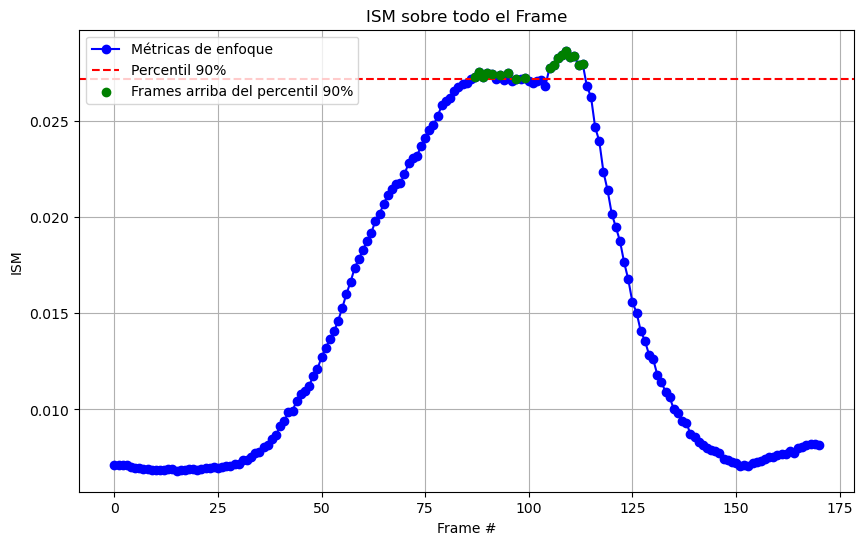

In [125]:
# Calcular la métrica de enfoque ISM sobre todo el Frame con percentil 90% para máximo enfoque.
title= f'ISM sobre todo el Frame' 
percentile=90
fm='ISM'

metrics,pts = focus_measure(video_frames, 1,fm,21)

# Mostrar las métricas de enfoque
showMetric(metrics, percentile,title,fm)

enfoco = [ m >= np.percentile(metrics, percentile) for m in metrics]

showVideo(video_frames,delay,title,pts,enfoco)
    


##### 1.2 - Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.

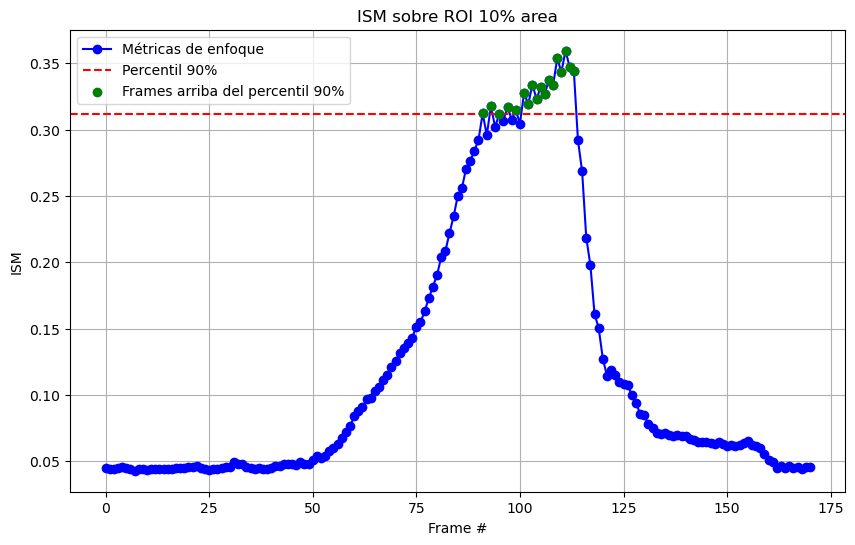

In [126]:
# Calcular la métrica de enfoque ISM sobre una ROI de 10% area con percentil 90% para máximo enfoque.

title= f'ISM sobre ROI 10% area'
percentile=90
fm='ISM'
roi=0.1

metrics,pts = focus_measure(video_frames, roi,fm)

# Mostrar las métricas de enfoque
showMetric(metrics, percentile,title,fm)

enfoco = [ m >= np.percentile(metrics, percentile) for m in metrics]

showVideo(video_frames,delay,title,pts,enfoco)
    

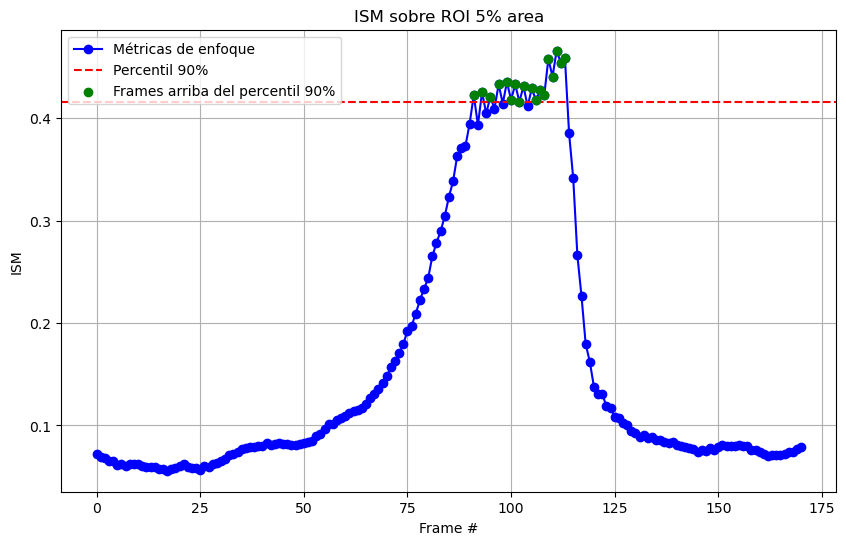

In [127]:
# Calcular la métrica de enfoque ISM sobre una ROI de 5% area con percentil 90% para máximo enfoque.

title= f'ISM sobre ROI 5% area'
percentile=90
fm='ISM'
roi=0.05

metrics,pts = focus_measure(video_frames, roi,fm)

# Mostrar las métricas de enfoque
showMetric(metrics, percentile,title,fm)

enfoco = [ m >= np.percentile(metrics, percentile) for m in metrics]

showVideo(video_frames,delay,title,pts,enfoco)

##### 1.3 Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados.                  N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc ... (al menos 3) 

In [128]:
# Set de matrices para probar el enfoque
# 'rect: Dimensiones de los rectangulos equiespaciados (ancho y alto)
#  dim:  Dimensiones de la matriz (filas y Columnas)
#  sep:  Separación entre rectángulos de la matriz

mats = [{ 'rect': (10, 15), 'dim': (5, 7), 'sep': 10 },
        { 'rect': (50, 50), 'dim': (3, 3), 'sep': 10 },
        { 'rect': (20, 30), 'dim': (4, 5), 'sep': 20 },
        { 'rect': (30, 30), 'dim': (7, 5), 'sep': 10 }]

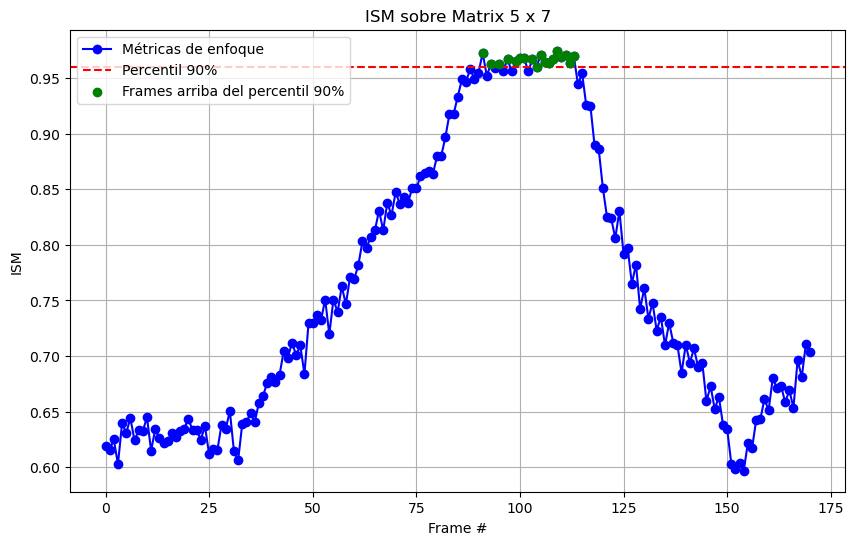

In [129]:
#Medicion ISM sobre una matriz de 5x7 con percentil 90% para máximo enfoque.
matrix=mats[0]

percentile=90
fm='ISM'

title= f"{fm} sobre Matrix {matrix['dim'][0]} x {matrix['dim'][1]}"

metricas_enfoque,pts = focus_measure_matrix(video_frames, matrix,fm)
    
showMetric(metricas_enfoque,percentile,title,fm)

enfoco = [ m >= np.percentile(metricas_enfoque, percentile) for m in metricas_enfoque]

showVideoMatrix(video_frames,delay,title,pts,enfoco)

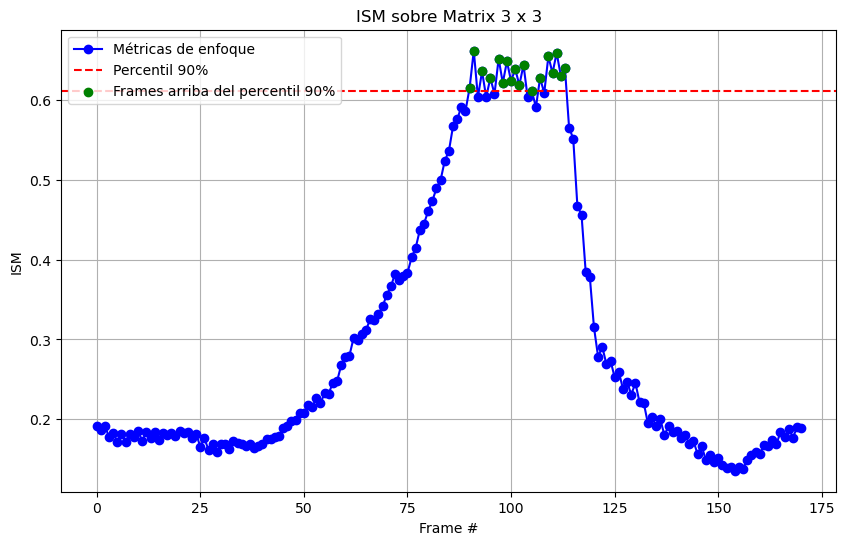

In [130]:
#Medicion ISM sobre una matriz de 3x3 con percentil 90% para máximo enfoque.
matrix=mats[1]

percentile=90
fm='ISM'

title= f"{fm} sobre Matrix {matrix['dim'][0]} x {matrix['dim'][1]}"

metricas_enfoque,pts = focus_measure_matrix(video_frames, matrix,fm)
    
showMetric(metricas_enfoque,percentile,title,fm)

enfoco = [ m >= np.percentile(metricas_enfoque, percentile) for m in metricas_enfoque]

showVideoMatrix(video_frames,delay,title,pts,enfoco)

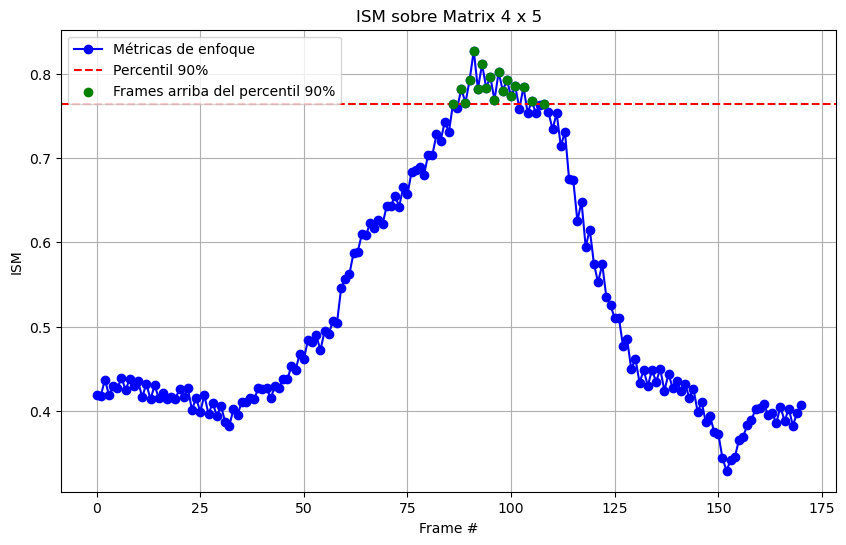

In [131]:
#Medicion ISM sobre una matriz de 4x5 con percentil 90% para máximo enfoque.
matrix=mats[2]

percentile=90
fm='ISM'

title= f"{fm} sobre Matrix {matrix['dim'][0]} x {matrix['dim'][1]}"

metricas_enfoque,pts = focus_measure_matrix(video_frames, matrix,fm)
    
showMetric(metricas_enfoque,percentile,title,fm)

enfoco = [ m >= np.percentile(metricas_enfoque, percentile) for m in metricas_enfoque]

showVideoMatrix(video_frames,delay,title,pts,enfoco)

### 2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

Seleccionamos la medida de enfoque LAP4 (varianza del Laplaciano)

#### 2.1 Medicion sobre todo el frame

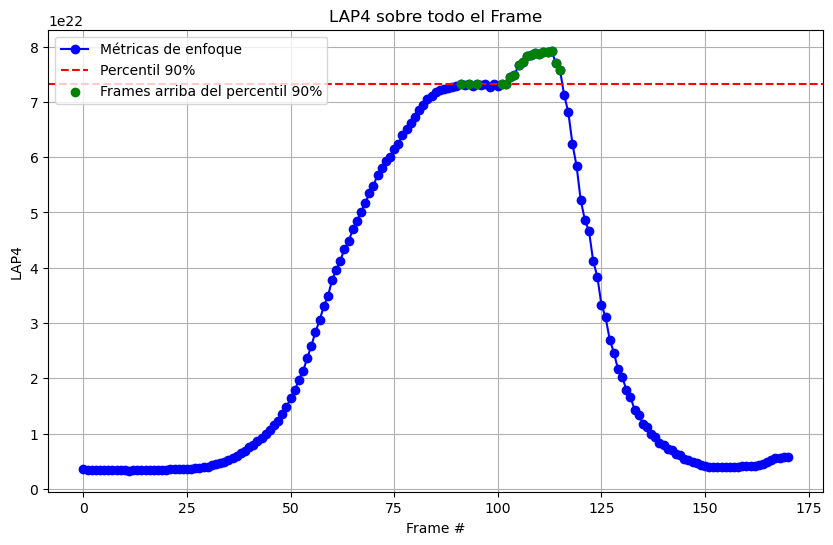

In [132]:
# Calcular la métrica de enfoque LAP4 sobre todo el Frame con percentil 90% para máximo enfoque.

title= f'LAP4 sobre todo el Frame' 
percentile=90
fm='LAP4'

metrics,pts = focus_measure(video_frames, 1,fm)

# Mostrar las métricas de enfoque
showMetric(metrics, percentile,title,fm)

enfoco = [ m >= np.percentile(metrics, percentile) for m in metrics]

showVideo(video_frames,delay,title,pts,enfoco)
    

#### 2.2 Medicion sobre una ROI

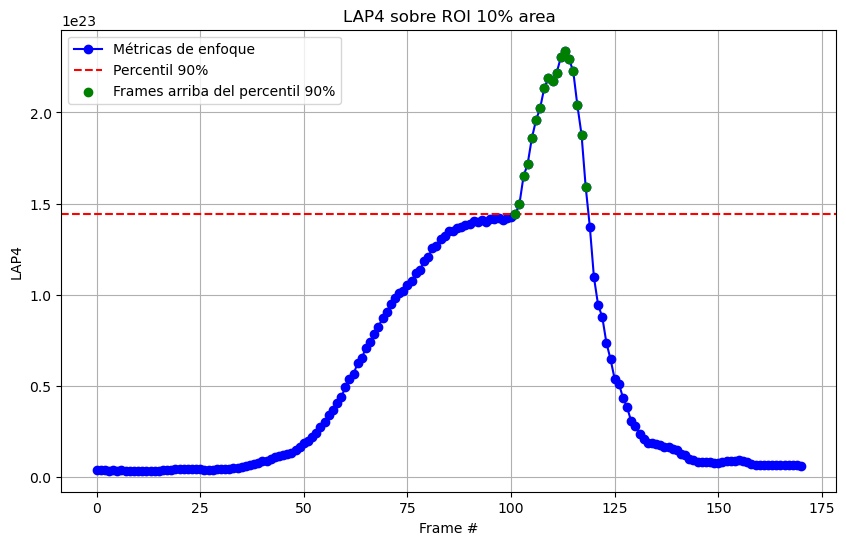

In [133]:
#Medicion LAP4 sobre una ROI de 10% Area con percentil 90% para máximo enfoque.

title= f'LAP4 sobre ROI 10% area'
percentile=90
fm='LAP4'
roi=0.1

metrics,pts = focus_measure(video_frames, roi,fm)

# Mostrar las métricas de enfoque
showMetric(metrics, percentile,title,fm)

enfoco = [ m >= np.percentile(metrics, percentile) for m in metrics]

showVideo(video_frames,delay,title,pts,enfoco)
    

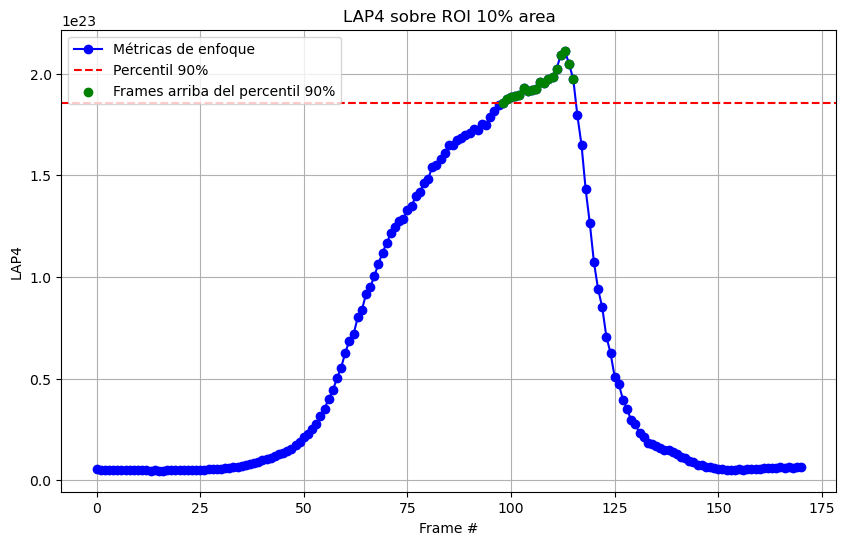

In [134]:
#Medicion LAP4 sobre una ROI de 5% Area con percentil 90% para máximo enfoque.

title= f'LAP4 sobre ROI 10% area'
percentile=90
fm='LAP4'
roi=0.05

metrics,pts = focus_measure(video_frames, roi,fm)

# Mostrar las métricas de enfoque
showMetric(metrics, percentile,title,fm)

enfoco = [ m >= np.percentile(metrics, percentile) for m in metrics]

showVideo(video_frames,delay,title,pts,enfoco)
    

#### 2.3 Medicion sobre una matriz

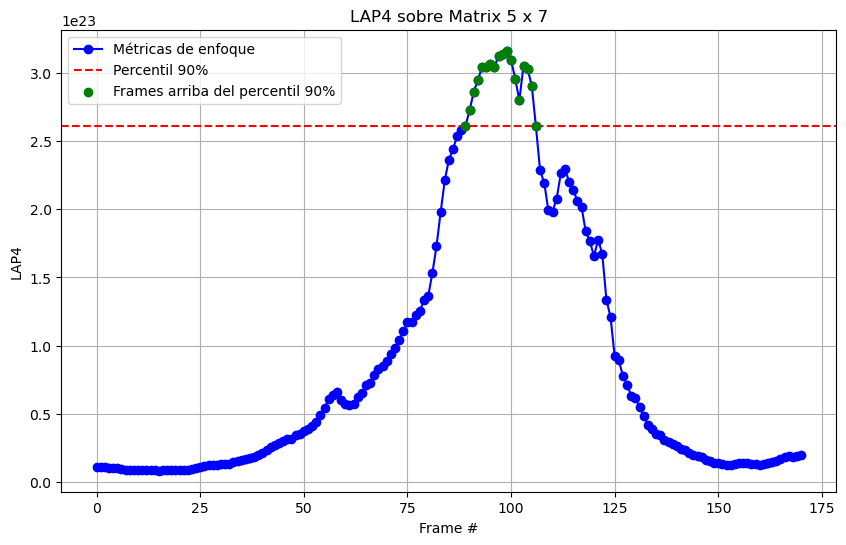

In [135]:
#Medicion LAP4 sobre una matriz de 5x7 con percentil 90% para máximo enfoque.
matrix=mats[0]

window_size=21
percentile=90
fm='LAP4'

title= f"{fm} sobre Matrix {matrix['dim'][0]} x {matrix['dim'][1]}"

metricas_enfoque,pts = focus_measure_matrix(video_frames, matrix,fm,window_size)
    
showMetric(metricas_enfoque,percentile,title,fm)

enfoco = [ m >= np.percentile(metricas_enfoque, percentile) for m in metricas_enfoque]

showVideoMatrix(video_frames,delay,title,pts,enfoco)

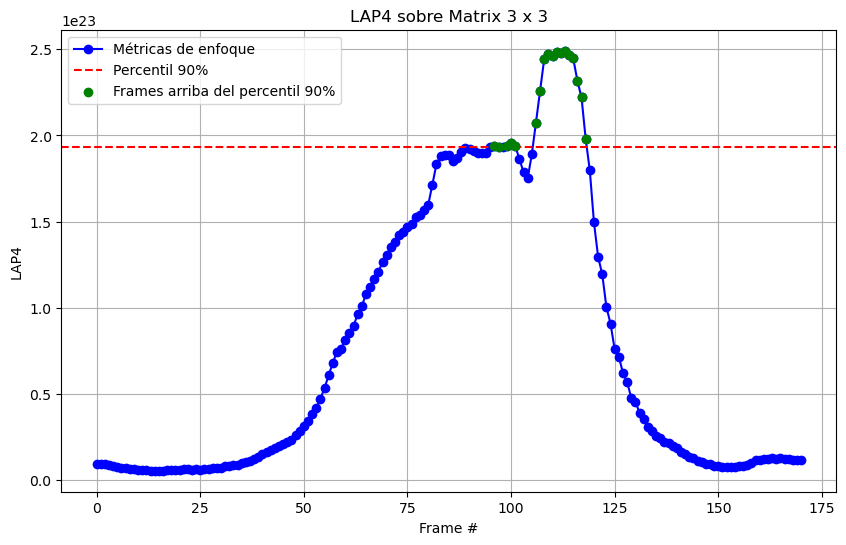

In [136]:
#Medicion LAP4 sobre una matriz de 3x3 con percentil 90% para máximo enfoque.
matrix=mats[1]

window_size=21
percentile=90
fm='LAP4'

title= f"{fm} sobre Matrix {matrix['dim'][0]} x {matrix['dim'][1]}"

metricas_enfoque,pts = focus_measure_matrix(video_frames, matrix,fm,window_size)
    
showMetric(metricas_enfoque,percentile,title,fm)

enfoco = [ m >= np.percentile(metricas_enfoque, percentile) for m in metricas_enfoque]

showVideoMatrix(video_frames,delay,title,pts,enfoco)

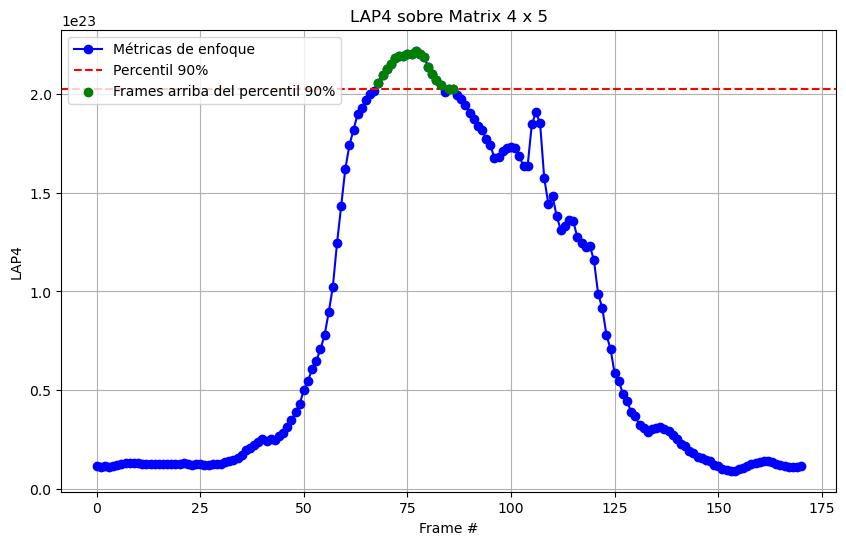

In [137]:
#Medicion LAP4 sobre una matriz de 4x5 con percentil 90% para máximo enfoque.
matrix=mats[2]

window_size=21
percentile=90
fm='LAP4'

title= f"{fm} sobre Matrix {matrix['dim'][0]} x {matrix['dim'][1]}"

metricas_enfoque,pts = focus_measure_matrix(video_frames, matrix,fm,window_size)
    
showMetric(metricas_enfoque,percentile,title,fm)

enfoco = [ m >= np.percentile(metricas_enfoque, percentile) for m in metricas_enfoque]

showVideoMatrix(video_frames,delay,title,pts,enfoco)

### 3. Aplicar unsharp masking para expandir la zona de enfoque y devolver.

In [ ]:
def unsharp_masking(image, size,sigma,k):
    """
    Aplica unsharp masking a la imagen
    Devuelve imagen ajustada
    """
    gauss = cv.GaussianBlur(image, size,sigma)
    new_img = cv.addWeighted(image, k + 1, gauss, -k, 0)
    
    return new_img

In [ ]:
showImage(video_frames[0],'Frame Original')
showImage(unsharp_masking(video_frames[0],(7,7),1,10),'Frame con Unsharp Masking')

In [138]:
#TODO: Implementar